## Cloning the Repo

In [ ]:
!git clone https://github.com/peppermenta/faceHack

fatal: destination path 'faceHack' already exists and is not an empty directory.


## Installing Dependencies

In [ ]:
!pip3 install -r faceHack/requirements.txt

## Creating the Dataset

In [ ]:
import torch
from PIL import Image
import numpy as np
import os      
import torchvision         

class FaceDataset(torch.utils.data.Dataset):
  def __init__(self,train=True,type='normal',transform=None):
    super().__init__()
    if(train):
      self.data = np.genfromtxt(os.path.join('faceHack','dataset','train.csv'),delimiter=',',dtype=None,encoding='utf-8')
    else:
      self.data = np.genfromtxt(os.path.join('faceHack','dataset','test.csv'),delimiter=',',dtype=None,encoding='utf-8')
    if type != 'normal':
      temp = []
      for i in range(self.data.shape[0]):
        if self.data[i][1] != 'NOT smile':
          temp.append(self.data[i])
      self.data = np.array(temp)
    self.type=type
    self.transform = transform

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, index):
    img_name = self.data[index][0]
    X = Image.open(os.path.join('faceHack','dataset','happy_images','{}.jpg'.format(img_name)))
    label = self.data[index][1]

    if(self.type=='normal'):
      if(label=='NOT smile'):
        y = 0
      else:
        y = 1
    else:
      if(label=='positive smile'):
        y = 1
      else:
        y = 0

    if(self.transform):
      X = self.transform(X)
    return X,y


## Defining the Transform

In [ ]:
faceTransform = torchvision.transforms.Compose([
  torchvision.transforms.Resize(224),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ToTensor(),
])

## Setting up the Smile vs. No-Smile Model

In [ ]:
device = torch.device('cuda')
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnext101_32x8d', pretrained=True)
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False
for param in model.layer4.parameters():
  param.requires_grad = True

in_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=in_features,out_features=128),
    torch.nn.Linear(in_features=128,out_features=2)
)

model = model.to(device)

trainDataset = FaceDataset(transform=faceTransform)
testDataset = FaceDataset(train=False,transform=faceTransform)
trainLoader = torch.utils.data.DataLoader(trainDataset,batch_size=32,shuffle=True,num_workers=2)
testLoader = torch.utils.data.DataLoader(testDataset,batch_size=32,shuffle=False,num_workers=2)

cuda


## Training the Smile vs. No-Smile Model


Epoch:(0,0): Loss=1.1086190938949585
Epoch:(0,20): Loss=0.905098021030426
Epoch:(0,40): Loss=0.7981089949607849
Epoch:(0,60): Loss=0.9137798547744751
Epoch:(0,80): Loss=0.8351609706878662
Epoch:(0,100): Loss=1.0241938829421997
Epoch:(0,120): Loss=0.8455922603607178
Epoch:(0,140): Loss=0.9184404015541077
Train Accuracy is 0.7938315048644173
Test accuracy is 0.8435754189944135
Epoch:(1,0): Loss=0.7491598725318909
Epoch:(1,20): Loss=0.8910004496574402
Epoch:(1,40): Loss=0.8091772198677063
Epoch:(1,60): Loss=0.7487922310829163
Epoch:(1,80): Loss=0.8106798529624939
Epoch:(1,100): Loss=0.7788881659507751
Epoch:(1,120): Loss=0.8296016454696655
Epoch:(1,140): Loss=0.6947898864746094
Train Accuracy is 0.8724901676671497
Test accuracy is 0.8286778398510242
Epoch:(2,0): Loss=0.5703455209732056
Epoch:(2,20): Loss=0.7601328492164612
Epoch:(2,40): Loss=0.7298794388771057
Epoch:(2,60): Loss=0.5441134572029114
Epoch:(2,80): Loss=0.6886284351348877
Epoch:(2,100): Loss=0.6506853699684143
Epoch:(2,120): 

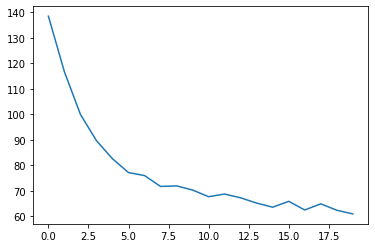

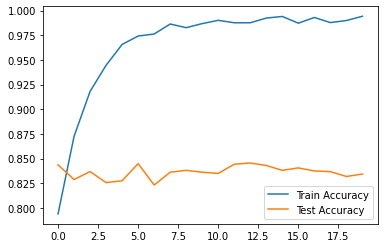

In [ ]:
model.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.0001)
epochs = 20
lambda1 = 0.0001

loss_hist = []
train_acc_hist = []
test_acc_hist = []
best_test = 0
for epoch in range(epochs):
  tot_loss = 0
  correct = 0
  for i,data in enumerate(trainLoader):
    X,y = data
    X = X.to(device)
    y = y.to(device)

    out = model(X)

    _,pred = torch.max(out,dim=1)
    correct += (pred==y).sum().item()

    loss = criterion(out,y)
    for p in model.parameters():
      if p.requires_grad == True:
        loss += lambda1*torch.sum(p**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    tot_loss += loss.item()
    if(i%20==0):
      print('Epoch:({},{}): Loss={}'.format(epoch,i,loss.item()))

  loss_hist.append(tot_loss)
  print('Train Accuracy is {}'.format(correct/len(trainDataset)))
  train_acc_hist.append(correct/len(trainDataset))

  test_correct = 0
  with torch.no_grad():
    for X,y in testLoader:
      X = X.to(device)
      y = y.to(device)
      out = model(X)
      _,pred = torch.max(out,dim=1)
      test_correct += (pred==y).sum().item()
  if test_correct > best_test:
    best_test = test_correct
    torch.save(model.state_dict(), './smile_best_weights.pt')
  print('Test accuracy is {}'.format(test_correct/len(testDataset)))
  test_acc_hist.append(test_correct/len(testDataset))

import matplotlib.pyplot as plt
print('Best Test Accuracy: {}'.format(best_test))
plt.plot([i for i in range(epochs)],loss_hist)
plt.show()
plt.plot([i for i in range(epochs)],train_acc_hist)
plt.plot([i for i in range(epochs)],test_acc_hist)
plt.legend(['Train Accuracy','Test Accuracy'])
plt.show()

## Setting up the Positive vs. Negative Smile Model

In [ ]:
device = torch.device('cuda')
print(device)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnext101_32x8d', pretrained=True)
model1 = torchvision.models.resnet18(pretrained=True)

for param in model1.parameters():
  param.requires_grad = False
for param in model1.layer4.parameters():
  param.requires_grad = True

in_features = model1.fc.in_features
model1.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=in_features,out_features=128),
    torch.nn.Linear(in_features=128,out_features=2)
)

model1 = model1.to(device)

trainDataset = FaceDataset(transform=faceTransform, type="posneg")
testDataset = FaceDataset(train=False,transform=faceTransform, type="posneg")
trainLoader = torch.utils.data.DataLoader(trainDataset,batch_size=32,shuffle=True,num_workers=2)
testLoader = torch.utils.data.DataLoader(testDataset,batch_size=32,shuffle=False,num_workers=2)

cuda


## Training the Positive vs. Negative Smile Model

Epoch:(0,0): Loss=1.1393613815307617
Epoch:(0,20): Loss=1.0496973991394043
Epoch:(0,40): Loss=1.1267502307891846
Train Accuracy is 0.6854237288135593
Test accuracy is 0.7142857142857143
Epoch:(1,0): Loss=1.0343255996704102
Epoch:(1,20): Loss=0.946516752243042
Epoch:(1,40): Loss=0.8892644047737122
Train Accuracy is 0.8135593220338984
Test accuracy is 0.7039337474120083
Epoch:(2,0): Loss=0.7773545384407043
Epoch:(2,20): Loss=0.821036696434021
Epoch:(2,40): Loss=0.7935656905174255
Train Accuracy is 0.9016949152542373
Test accuracy is 0.722567287784679
Epoch:(3,0): Loss=0.6342889070510864
Epoch:(3,20): Loss=0.5772280693054199
Epoch:(3,40): Loss=0.5965115427970886
Train Accuracy is 0.9430508474576271
Test accuracy is 0.7204968944099379
Epoch:(4,0): Loss=0.5396691560745239
Epoch:(4,20): Loss=0.567621648311615
Epoch:(4,40): Loss=0.5077978372573853
Train Accuracy is 0.9559322033898305
Test accuracy is 0.7039337474120083
Epoch:(5,0): Loss=0.5268551707267761
Epoch:(5,20): Loss=0.4886639416217804

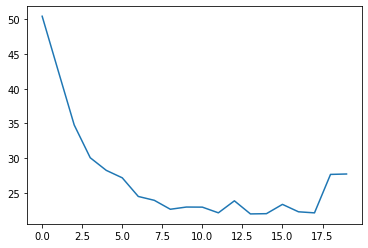

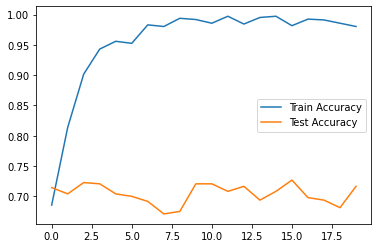

In [ ]:
model1.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()),lr=0.0001)
epochs = 20
lambda1 = 0.0001

loss_hist = []
train_acc_hist = []
test_acc_hist = []
best_test = 0
for epoch in range(epochs):
  tot_loss = 0
  correct = 0
  for i,data in enumerate(trainLoader):
    X,y = data
    X = X.to(device)
    y = y.to(device)

    out = model1(X)

    _,pred = torch.max(out,dim=1)
    correct += (pred==y).sum().item()

    loss = criterion(out,y)
    for p in model1.parameters():
      if p.requires_grad == True:
        loss += lambda1*torch.sum(p**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    tot_loss += loss.item()
    if(i%20==0):
      print('Epoch:({},{}): Loss={}'.format(epoch,i,loss.item()))

  loss_hist.append(tot_loss)
  print('Train Accuracy is {}'.format(correct/len(trainDataset)))
  train_acc_hist.append(correct/len(trainDataset))

  test_correct = 0
  with torch.no_grad():
    for X,y in testLoader:
      X = X.to(device)
      y = y.to(device)
      out = model1(X)
      _,pred = torch.max(out,dim=1)
      test_correct += (pred==y).sum().item()
  if test_correct > best_test:
    best_test = test_correct
    torch.save(model1.state_dict(), './smile_best_weights_posneg.pt')
  print('Test accuracy is {}'.format(test_correct/len(testDataset)))
  test_acc_hist.append(test_correct/len(testDataset))

import matplotlib.pyplot as plt
print('Best Test Accuracy: {}'.format(best_test))
plt.plot([i for i in range(epochs)],loss_hist)
plt.show()
plt.plot([i for i in range(epochs)],train_acc_hist)
plt.plot([i for i in range(epochs)],test_acc_hist)
plt.legend(['Train Accuracy','Test Accuracy'])
plt.show()

## Reporting Final Test Accuracy(Both Models combined)

In [ ]:
model.load_state_dict(torch.load('./smile_best_weights.pt'))
model1.load_state_dict(torch.load('./smile_best_weights_posneg.pt'))
testDataset = FaceDataset(train=False,transform=faceTransform)
testLoader = torch.utils.data.DataLoader(testDataset,batch_size=1,shuffle=False,num_workers=2)
model = model.to(device)
model1 = model1.to(device)
model.eval()
model1.eval()
labels = []
true_labels = []
for X,y in testLoader:
  X = X.to(device)
  out = model(X)
  _,pred = torch.max(out,dim=1)
  if pred == 0:
    labels.append(0)
  else:
    out = model1(X)
    _,pred = torch.max(out,dim=1)
    labels.append(pred.item() + 1)
for i in range(testDataset.data.shape[0]):
  true_label = testDataset.data[i][1]
  if true_label == 'NOT smile':
    true_labels.append(0)
  elif true_label == 'negative smile':
    true_labels.append(1)
  else:
    true_labels.append(2)
count = 0
for i in range(len(labels)):
  if labels[i] == true_labels[i]:
    count += 1
print(count / len(true_labels))



0.7920546244568591
